# Approximate functions using decaying exponentials using the Matrix Pencil Method (MPM) and reduction algorithm from Beylkin Monzon 2005

### Note: this code works well for generating quadratures that are accurate to about single precision. If you want to make double precision quadratures, this algorithm requires complex data types derived from quad precision to generate the quadratures. Once generated, double precision will be sufficient to use the quadratures.

In [35]:
#using Pkg
#Pkg.add("GenericLinearAlgebra")

using SpecialFunctions
using LinearAlgebra
using GenericLinearAlgebra
using Plots

# Use roughly quad precision
setprecision(128)

128

In [26]:
# Create functional samples to fill Hankel matrix. Note that you need an odd number of samples
# and that the weight function must be included in the sampling

num_samples = BigFloat(501)
@assert mod(num_samples,2)!=0

N = (num_samples-1)/2
N_int = convert(Int128,N)
h = [besselj0(BigFloat(100)*BigFloat(pi)*n/num_samples) for n=0:num_samples-1];# computed by evaluating integral (6) in the paper. 1/pi to remove pi in Julia sinc expression

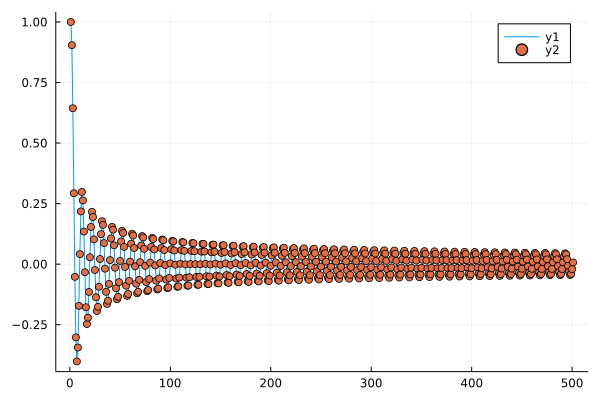

In [31]:
plot(h)
scatter!(1:num_samples,h)

In [32]:
# Form a Toeplitz matrix from the samples G. Note: be careful with data types!
H_matrix = zeros(BigFloat,N_int+1,N_int+1)
for n = 0:N_int
    for np = 0:N_int
        H_matrix[n+1,np+1] = h[n+np+1]
    end
end

In [36]:
# compute the SVD
U,s,V = svd(H_matrix);

# Note: this can take a while!

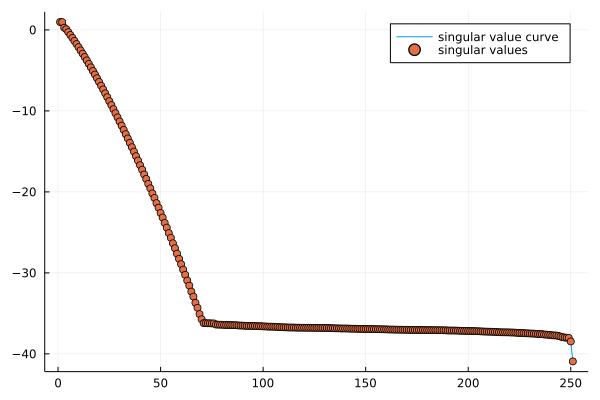

In [37]:
# plot the singular values, figure out which one you want
plot(log10.(s),label="singular value curve")
scatter!(1:length(s),log10.(s),label="singular values")

In [43]:
# Select singular value index. Note that this number +1 should give you the accuracy you want
s_index=37
s[s_index]/s[1]

9.934601557705384794903772741189736131845e-17

In [44]:
# Carve up U and construct the eigenvalue matrix
U_tilde = U[1:N_int,1:s_index];
U_hat = U[2:N_int+1,1:s_index];

C_matrix = pinv(U_tilde)*U_hat;

In [45]:
# compute the eigenvalues of the matrix
nodes = eigvals(C_matrix);

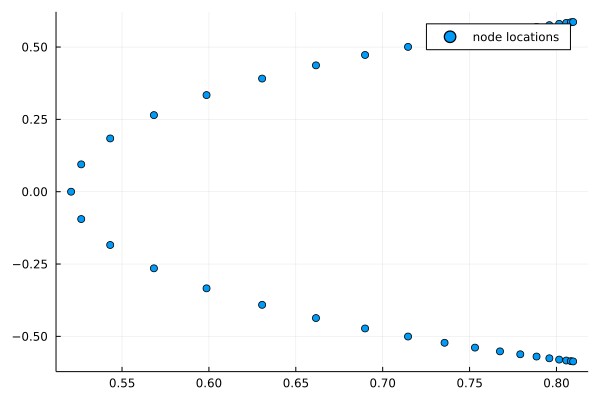

In [46]:
scatter(real(nodes),imag(nodes),label="node locations")

In [50]:
# compute the quadrature weights. Form a vandermonde matrix and solve using least squares
V_matrix = zeros(Complex{BigFloat},2*N_int+1,s_index)
for i = 1:2*N_int+1
    for j in 1:s_index
        V_matrix[i,j]= nodes[j]^(i-1)
    end
end

weights = V_matrix \ h;

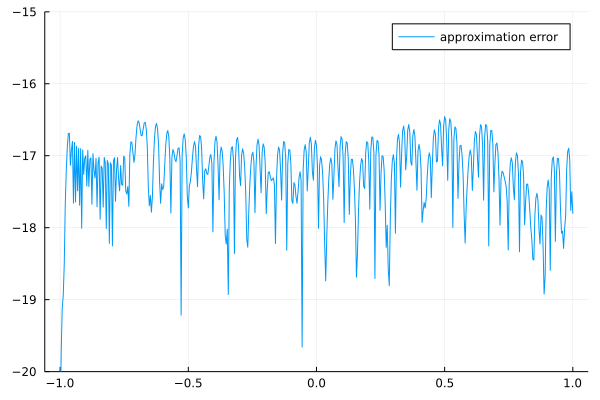

In [55]:
plot(range(-1,stop=1,length=2*N_int+1),log10.(abs.(V_matrix*weights-h)),ylims=(-20,-15),label="approximation error")

In [56]:
maximum(abs.(V_matrix*weights-h))

3.487939127661137766930495161379869380325e-17

In [57]:
# Extract exponentials so we can use continuous approximation
#quadrature_nodes = real(N/im/c*log.(nodes));

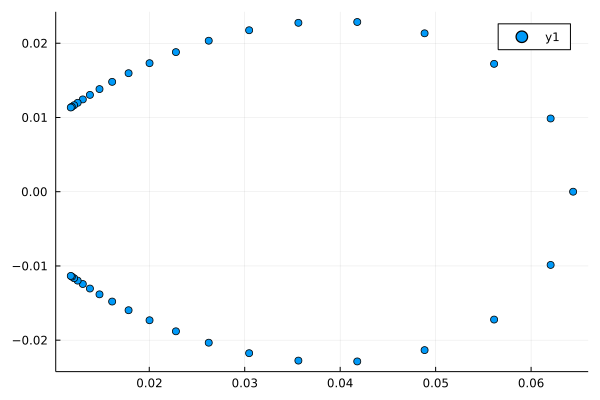

In [58]:
scatter(real(weights),imag(weights))